In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch.nn.init as init

# 데이터 로드 함수
def load_weather_data(file_path):
    """Weather 데이터셋을 로드하는 함수"""
    df = pd.read_csv(file_path)
    return df

# 데이터 전처리 함수
def preprocess_weather_data(df):
    """Weather 데이터 전처리를 수행하는 함수"""
    print("=== Data Preprocessing ===")
    print(f"Original data shape: {df.shape}")
    
    # 결측값 확인
    print("\nMissing values check:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    # 'NA' 값을 NaN으로 변환
    df = df.replace('NA', np.nan)
    
    # 숫자형 컬럼의 결측값을 평균으로 채우기
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mean(), inplace=True)
    
    # 범주형 컬럼의 결측값을 최빈값으로 채우기
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    # 불필요한 컬럼 제거 (Date, Location, RISK_MM)
    df = df.drop(['Date', 'Location', 'RISK_MM'], axis=1, errors='ignore')
    
    # 범주형 변수 인코딩
    le_dict = {}
    for col in df.select_dtypes(include=['object']).columns:
        if col != 'RainTomorrow':  # 타겟 변수는 별도 처리
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            le_dict[col] = le
    
    # 타겟 변수 인코딩
    le_target = LabelEncoder()
    df['RainTomorrow'] = le_target.fit_transform(df['RainTomorrow'])
    
    # 특성과 타겟 분리
    X = df.drop('RainTomorrow', axis=1)
    y = df['RainTomorrow']
    
    print(f"\nAfter preprocessing:")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Target distribution:\n{y.value_counts()}")
    
    return X, y, le_target, le_dict

# 데이터 탐색 함수
def explore_weather_data(df):
    """Weather 데이터 탐색을 수행하는 함수"""
    print("=== Weather Dataset Basic Information ===")
    print(f"Data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    print("\n=== Target Distribution ===")
    print(df['RainTomorrow'].value_counts())
    # 문자열을 숫자로 변환하여 확률 계산
    rain_prob = (df['RainTomorrow'] == 'Yes').mean()
    print(f"Rain probability: {rain_prob:.3f}")
    
    print("\n=== Basic Statistics ===")
    print(df.describe())
    
    print("\n=== Missing Values ===")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    return df

# 시각화 함수
def create_weather_visualizations(df):
    """Weather 데이터 시각화를 생성하는 함수"""
    plt.figure(figsize=(20, 15))
    
    # 1. 타겟 분포
    plt.subplot(3, 4, 1)
    rain_counts = df['RainTomorrow'].value_counts()
    rain_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
    plt.title('Rain Tomorrow Distribution')
    plt.xlabel('Rain Tomorrow')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    # 2. 온도 관련 특성들
    plt.subplot(3, 4, 2)
    temp_cols = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']
    for col in temp_cols:
        if col in df.columns:
            plt.hist(df[col].dropna(), alpha=0.6, label=col, bins=30)
    plt.title('Temperature Distribution')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 3. 습도 관련 특성들
    plt.subplot(3, 4, 3)
    humidity_cols = ['Humidity9am', 'Humidity3pm']
    for col in humidity_cols:
        if col in df.columns:
            plt.hist(df[col].dropna(), alpha=0.6, label=col, bins=30)
    plt.title('Humidity Distribution')
    plt.xlabel('Humidity')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 4. 강수량 분포
    plt.subplot(3, 4, 4)
    plt.hist(df['Rainfall'].dropna(), bins=50, alpha=0.7, color='blue')
    plt.title('Rainfall Distribution')
    plt.xlabel('Rainfall')
    plt.ylabel('Frequency')
    plt.yscale('log')  # 로그 스케일로 표시
    
    # 5. 기압 관련 특성들
    plt.subplot(3, 4, 5)
    pressure_cols = ['Pressure9am', 'Pressure3pm']
    for col in pressure_cols:
        if col in df.columns:
            plt.hist(df[col].dropna(), alpha=0.6, label=col, bins=30)
    plt.title('Pressure Distribution')
    plt.xlabel('Pressure')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 6. 바람 속도 관련 특성들
    plt.subplot(3, 4, 6)
    wind_cols = ['WindSpeed9am', 'WindSpeed3pm', 'WindGustSpeed']
    for col in wind_cols:
        if col in df.columns:
            plt.hist(df[col].dropna(), alpha=0.6, label=col, bins=30)
    plt.title('Wind Speed Distribution')
    plt.xlabel('Wind Speed')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 7. 구름 관련 특성들
    plt.subplot(3, 4, 7)
    cloud_cols = ['Cloud9am', 'Cloud3pm']
    for col in cloud_cols:
        if col in df.columns:
            plt.hist(df[col].dropna(), alpha=0.6, label=col, bins=30)
    plt.title('Cloud Coverage Distribution')
    plt.xlabel('Cloud Coverage')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 8. 증발량과 일조량
    plt.subplot(3, 4, 8)
    plt.scatter(df['Evaporation'], df['Sunshine'], alpha=0.5)
    plt.title('Evaporation vs Sunshine')
    plt.xlabel('Evaporation')
    plt.ylabel('Sunshine')
    
    # 9. 상관관계 히트맵 (숫자형 컬럼만)
    plt.subplot(3, 4, 9)
    numeric_df = df.select_dtypes(include=[np.number])
    if len(numeric_df.columns) > 1:
        corr_matrix = numeric_df.corr()
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
                    square=True, cbar_kws={"shrink": 0.8})
        plt.title('Feature Correlation Matrix')
    
    # 10. RainToday vs RainTomorrow
    plt.subplot(3, 4, 10)
    if 'RainToday' in df.columns:
        rain_cross = pd.crosstab(df['RainToday'], df['RainTomorrow'])
        rain_cross.plot(kind='bar', stacked=True)
        plt.title('Rain Today vs Rain Tomorrow')
        plt.xlabel('Rain Today')
        plt.ylabel('Count')
        plt.legend(['No Rain Tomorrow', 'Rain Tomorrow'])
        plt.xticks(rotation=0)
    
    # 11. 월별 강수 패턴 (Date 컬럼이 있다면)
    plt.subplot(3, 4, 11)
    if 'Date' in df.columns:
        df_temp = df.copy()
        df_temp['Date'] = pd.to_datetime(df_temp['Date'])
        df_temp['Month'] = df_temp['Date'].dt.month
        # RainTomorrow를 숫자로 변환 (Yes=1, No=0)
        df_temp['RainTomorrow_numeric'] = (df_temp['RainTomorrow'] == 'Yes').astype(int)
        monthly_rain = df_temp.groupby('Month')['RainTomorrow_numeric'].mean()
        monthly_rain.plot(kind='bar', color='green', alpha=0.7)
        plt.title('Monthly Rain Probability')
        plt.xlabel('Month')
        plt.ylabel('Rain Probability')
        plt.xticks(rotation=0)
    
    # 12. 특성별 강수 확률
    plt.subplot(3, 4, 12)
    feature_importance = []
    feature_names = []
    # RainTomorrow를 숫자로 변환
    df_numeric = df.copy()
    df_numeric['RainTomorrow_numeric'] = (df_numeric['RainTomorrow'] == 'Yes').astype(int)
    
    for col in numeric_df.columns:
        if col != 'RainTomorrow':
            rain_prob = df_numeric.groupby(pd.cut(df_numeric[col], bins=5))['RainTomorrow_numeric'].mean()
            if not rain_prob.isna().all():
                feature_importance.append(rain_prob.mean())
                feature_names.append(col)
    
    if feature_importance:
        plt.barh(feature_names[:10], feature_importance[:10])
        plt.title('Feature Rain Probability')
        plt.xlabel('Average Rain Probability')
    
    plt.tight_layout()
    plt.show()


In [2]:
# PyTorch 모델 정의
class WeatherMLPClassifier(nn.Module):
    """Weather 예측을 위한 다층 퍼셉트론 분류기"""
    def __init__(self, input_size, hidden_sizes=[256, 128, 64, 32], num_classes=2, dropout_rate=0.3):
        super(WeatherMLPClassifier, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)
        
        # 가중치 초기화
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x)

class WeatherCNNClassifier(nn.Module):
    """Weather 예측을 위한 1D CNN 분류기"""
    def __init__(self, input_size, num_classes=2, dropout_rate=0.3):
        super(WeatherCNNClassifier, self).__init__()
        
        # 1D CNN layers
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, input_size) -> (batch_size, 1, input_size)
        x = x.unsqueeze(1)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

class WeatherLSTMClassifier(nn.Module):
    """Weather 예측을 위한 LSTM 분류기"""
    def __init__(self, input_size, hidden_size=128, num_layers=3, num_classes=2, dropout_rate=0.3):
        super(WeatherLSTMClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, dropout=dropout_rate)
        
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, input_size) -> (batch_size, 1, input_size)
        x = x.unsqueeze(1)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Self-attention
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Global average pooling
        output = attn_output.mean(dim=1)
        output = self.dropout(output)
        
        output = F.relu(self.fc1(output))
        output = self.dropout(output)
        output = self.fc2(output)
        
        return output

# PyTorch 데이터셋 클래스
class WeatherDataset(Dataset):
    """Weather 데이터셋을 위한 PyTorch Dataset"""
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# PyTorch 모델들을 정의하는 함수
def get_weather_pytorch_models(input_size, num_classes=2):
    """다양한 Weather PyTorch 모델들을 반환하는 함수"""
    models = {
        'MLP': WeatherMLPClassifier(input_size, [256, 128, 64, 32], num_classes),
        'CNN': WeatherCNNClassifier(input_size, num_classes),
        'LSTM': WeatherLSTMClassifier(input_size, 128, 3, num_classes)
    }
    return models


In [3]:
# PyTorch 훈련 함수
def train_weather_model(model, train_loader, val_loader, num_epochs=150, learning_rate=0.001, device='cpu'):
    """Weather PyTorch 모델을 훈련하는 함수"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.5)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    early_stopping_patience = 30
    
    for epoch in range(num_epochs):
        # 훈련 모드
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()
        
        # 검증 모드
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()
        
        # 평균 계산
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # 학습률 스케줄링
        scheduler.step(avg_val_loss)
        
        # 최고 성능 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        # 진행 상황 출력 (20 에포크마다)
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # 최고 성능 모델 로드
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

# PyTorch 모델 평가 함수
def evaluate_weather_model(model, test_loader, le, device='cpu'):
    """Weather PyTorch 모델을 평가하는 함수"""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # 정확도 계산
    accuracy = accuracy_score(all_labels, all_predictions)
    
    # 분류 리포트
    target_names = le.classes_
    report = classification_report(all_labels, all_predictions, target_names=target_names, output_dict=True)
    
    # 혼동 행렬
    cm = confusion_matrix(all_labels, all_predictions)
    
    return accuracy, report, cm, all_predictions, all_labels, all_probabilities

# PyTorch 모델들을 학습하고 평가하는 함수
def train_and_evaluate_weather_models(X_train, X_val, X_test, y_train, y_val, y_test, models, le, device='cpu'):
    """Weather PyTorch 모델들을 학습하고 평가하는 함수"""
    results = {}
    training_histories = {}
    
    print("=== Weather PyTorch Model Performance Evaluation ===")
    print("-" * 80)
    
    # 데이터로더 생성
    train_dataset = WeatherDataset(X_train, y_train)
    val_dataset = WeatherDataset(X_val, y_val)
    test_dataset = WeatherDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    for name, model in models.items():
        print(f"\n{name} model training...")
        
        # 모델 훈련
        training_result = train_weather_model(model, train_loader, val_loader, device=device)
        training_histories[name] = training_result
        
        # 모델 평가
        accuracy, report, cm, predictions, labels, probabilities = evaluate_weather_model(
            training_result['model'], test_loader, le, device
        )
        
        results[name] = {
            'accuracy': accuracy,
            'report': report,
            'confusion_matrix': cm,
            'predictions': predictions,
            'labels': labels,
            'probabilities': probabilities
        }
        
        print(f"\n{name} model results:")
        print(f"Test accuracy: {accuracy:.4f}")
        print(f"Best validation accuracy: {training_result['best_val_acc']:.2f}%")
        
        # 상세 분류 리포트
        print("Classification report:")
        target_names = le.classes_
        print(classification_report(labels, predictions, target_names=target_names))
        
        # 혼동 행렬
        print("Confusion matrix:")
        print(cm)
        print("-" * 80)
    
    return results, training_histories

# 훈련 히스토리 시각화 함수
def plot_weather_training_history(training_histories):
    """Weather 훈련 히스토리를 시각화하는 함수"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for i, (name, history) in enumerate(training_histories.items()):
        # Loss 그래프
        axes[0].plot(history['train_losses'], label=f'{name} Train', alpha=0.7)
        axes[0].plot(history['val_losses'], label=f'{name} Val', alpha=0.7)
        axes[0].set_title('Training Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        # Accuracy 그래프
        axes[1].plot(history['train_accuracies'], label=f'{name} Train', alpha=0.7)
        axes[1].plot(history['val_accuracies'], label=f'{name} Val', alpha=0.7)
        axes[1].set_title('Training Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy (%)')
        axes[1].legend()
        axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# 특성 중요도 분석 함수 (그래디언트 기반)
def analyze_weather_feature_importance(model, X, y, feature_names, device='cpu'):
    """Weather PyTorch 모델의 특성 중요도를 분석하는 함수 (그래디언트 기반)"""
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.LongTensor(y).to(device)
    
    # 그래디언트 계산을 위해 requires_grad=True 설정
    X_tensor.requires_grad_(True)
    
    # Forward pass
    outputs = model(X_tensor)
    loss = F.cross_entropy(outputs, y_tensor)
    
    # 그래디언트 계산
    gradients = torch.autograd.grad(loss, X_tensor, create_graph=True)[0]
    
    # 특성별 중요도 (그래디언트의 절댓값 평균)
    feature_importance = torch.abs(gradients).mean(dim=0).cpu().detach().numpy()
    
    # 정규화
    feature_importance = feature_importance / feature_importance.sum()
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("=== Weather Model Feature Importance (Gradient-based) ===")
    print(importance_df.head(15))
    
    # 시각화
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title('Top 15 Feature Importance (Gradient-based)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return importance_df


Using device: cuda
=== Weather Dataset Basic Information ===
Data shape: (366, 24)
Columns: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow']

=== Target Distribution ===
RainTomorrow
No     300
Yes     66
Name: count, dtype: int64
Rain probability: 0.180

=== Basic Statistics ===
          MinTemp     MaxTemp    Rainfall  Evaporation    Sunshine  \
count  366.000000  366.000000  366.000000   366.000000  363.000000   
mean     7.265574   20.550273    1.428415     4.521858    7.909366   
std      6.025800    6.690516    4.225800     2.669383    3.481517   
min     -5.300000    7.600000    0.000000     0.200000    0.000000   
25%      2.300000   15.025000    0.000000     2.200000    5.950000   
50%      7.450000   19.65000

/tmp/ipykernel_104485/2263164606.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipykernel_104485/2263164606.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Epoch [20/150], Train Loss: 0.3973, Train Acc: 83.11%, Val Loss: 0.4036, Val Acc: 80.82%
Epoch [40/150], Train Loss: 0.2249, Train Acc: 93.15%, Val Loss: 0.4203, Val Acc: 79.45%
Early stopping at epoch 41

MLP model results:
Test accuracy: 0.8243
Best validation accuracy: 83.56%
Classification report:
              precision    recall  f1-score   support

          No       0.89      0.90      0.89        61
         Yes       0.50      0.46      0.48        13

    accuracy                           0.82        74
   macro avg       0.69      0.68      0.69        74
weighted avg       0.82      0.82      0.82        74

Confusion matrix:
[[55  6]
 [ 7  6]]
--------------------------------------------------------------------------------

CNN model training...
Epoch [20/150], Train Loss: 0.3391, Train Acc: 86.30%, Val Loss: 0.3646, Val Acc: 82.19%
Epoch [40/150], Train Loss: 0.3222, Train Acc: 87.21%, Val Loss: 0.3782, Val Acc: 80.82%
Early stopping at epoch 56

CNN model results:
Test

/home/luili0307/Desktop/Code/Machine_Learning/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luili0307/Desktop/Code/Machine_Learning/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luili0307/Desktop/Code/Machine_Learning/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

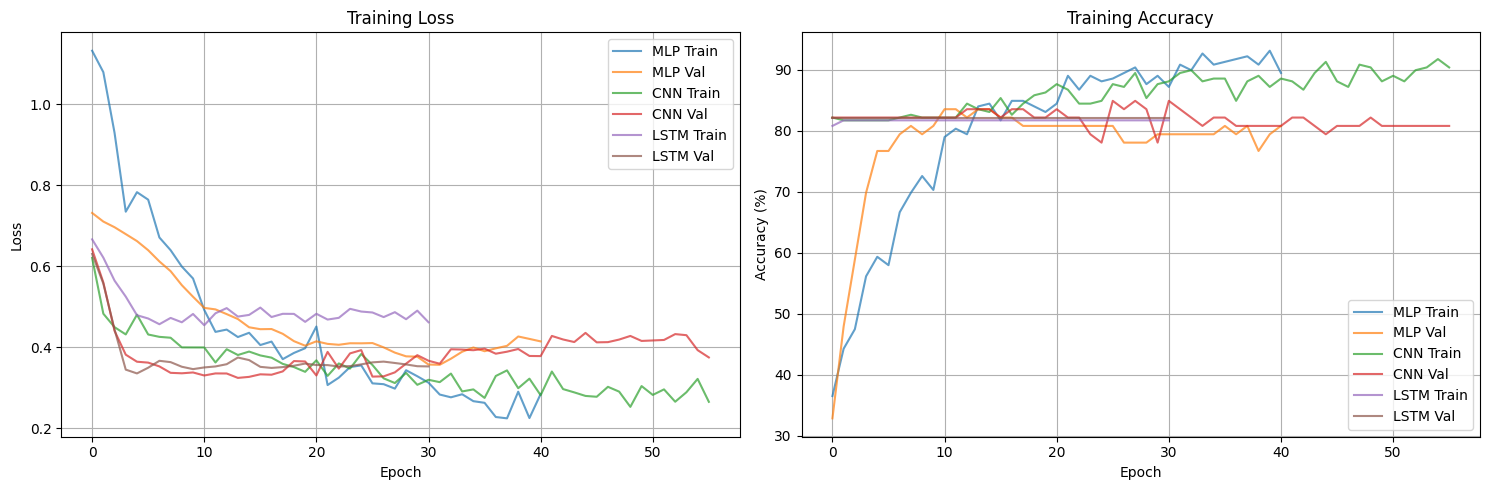


=== Best Performing Weather Model ===
Model: MLP
Test accuracy: 0.8243
Best validation accuracy: 83.56%


In [9]:
# 메인 실행 코드
def main_weather_classification():
    """Weather 분류 메인 함수"""
    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 데이터 로드
    file_path = 'dataset/weather/weather.csv'
    df = load_weather_data(file_path)
    
    # 데이터 탐색
    explore_weather_data(df)
    
    # 데이터 전처리
    X, y, le_target, le_dict = preprocess_weather_data(df)
    
    # 특성 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 데이터 분할 (훈련/검증/테스트)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
    )
    
    # pandas Series를 numpy array로 변환
    y_train = y_train.values
    y_val = y_val.values
    y_test = y_test.values
    
    print(f"Training set size: {X_train.shape}")
    print(f"Validation set size: {X_val.shape}")
    print(f"Test set size: {X_test.shape}")
    print()
    
    # PyTorch 모델 정의
    input_size = X_train.shape[1]
    num_classes = len(le_target.classes_)
    models = get_weather_pytorch_models(input_size, num_classes)
    
    # 모델 학습 및 평가
    results, training_histories = train_and_evaluate_weather_models(
        X_train, X_val, X_test, y_train, y_val, y_test, models, le_target, device
    )
    
    # 훈련 히스토리 시각화
    plot_weather_training_history(training_histories)
    
    # 최고 성능 모델 찾기
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    best_accuracy = results[best_model_name]['accuracy']
    
    print(f"\n=== Best Performing Weather Model ===")
    print(f"Model: {best_model_name}")
    print(f"Test accuracy: {best_accuracy:.4f}")
    print(f"Best validation accuracy: {training_histories[best_model_name]['best_val_acc']:.2f}%")

    return results, training_histories, importance_df

# 실행
if __name__ == "__main__":
    results, training_histories, importance_df = main_weather_classification()
